In [1]:
#import the essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data: `Blobs` dataset

In [2]:
from sklearn.datasets import make_blobs

Generate a dataset with:
- 2000 samples with 10 features each;
- 8 classes of blobs (centers argument);
- cluster_std = 7

In [3]:
X, y = make_blobs(n_samples=2000, n_features=10, centers=8, cluster_std=7, random_state=0)

In [4]:
print(f'X.shape={X.shape}')
print(f'y.shape={y.shape}')

X.shape=(2000, 10)
y.shape=(2000,)


# Visualize the data

All the samples have 10 features. Lets plot one dimension against another

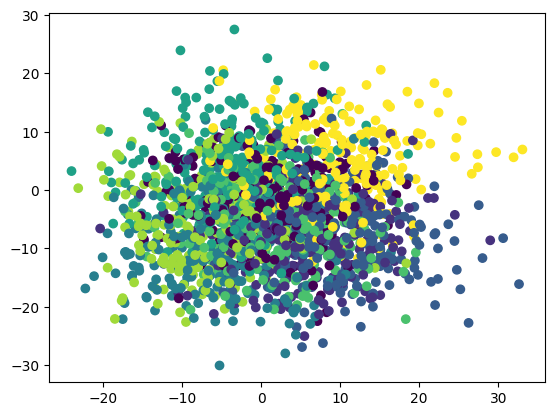

In [5]:
plt.scatter(X.T[0], X.T[4], c=y)

In [6]:
len(X.T[2])

2000

# Target encoding

In [7]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y, dtype='uint8')
y_cat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

# Neural Network model

Create a function for a neural network model with the following architecture:
- 25 neurons in the input layer with the appropriate input dimension and activation = 'relu'
- hidden layer with 10 neurons and activation = 'relu'
- predictive layer suited for the problem

Compilation method with:
- categorical crossentropy loss
- adam optimizer
- accuracy metrics

In [8]:
from tensorflow.keras import Sequential, models
from tensorflow.keras import layers

In [9]:
def initialize_model():
    
    '''Architecture'''
    model = Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=10))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    '''Compilation'''
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics='accuracy')
    
    return model

# Cross-validation 

Create a loop using K-Fold from sklearn:
- choose 10 folds to fit the model on the train data
- evaluate the model on test data and store the results

In [10]:
%%time

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = initialize_model()
    
    model.fit(X_train_scaled, 
              y_train,
              epochs=150,
              batch_size=16,
              verbose=0
             )
    
    result = model.evaluate(X_test_scaled, y_test, verbose=0)
    results.append(result)

2023-09-11 22:48:53.380843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 1min 15s, sys: 22.9 s, total: 1min 37s
Wall time: 1min 4s


In [11]:
results

[[0.737140953540802, 0.7099999785423279],
 [0.7314703464508057, 0.7350000143051147],
 [0.6856945753097534, 0.75],
 [0.7458443641662598, 0.7300000190734863],
 [0.784701943397522, 0.7250000238418579],
 [0.7854071855545044, 0.7350000143051147],
 [0.7579283118247986, 0.7599999904632568],
 [0.7690494656562805, 0.7599999904632568],
 [0.8330667614936829, 0.7099999785423279],
 [0.6319875121116638, 0.7599999904632568]]

In [12]:
accuracy = []

for i in results:
    accuracy.append(i[1])
    
mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'accuracy = {mean_accuracy}')
print(f'std_accuracy = {std_accuracy}')

accuracy = 0.7375
std_accuracy = 0.018472953330981624


# Holdout Method

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=42)

In [11]:
%%time

model = initialize_model()

history = model.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=16,
          epochs=150,
          verbose=0,
          shuffle=True)

2023-09-12 22:46:11.869040: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 6.72 s, sys: 1.64 s, total: 8.36 s
Wall time: 6.11 s


In [12]:
results = model.evaluate(X_test, y_test, verbose=0)

In [13]:
accuracy = results[1]
accuracy

0.7099999785423279

In [14]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

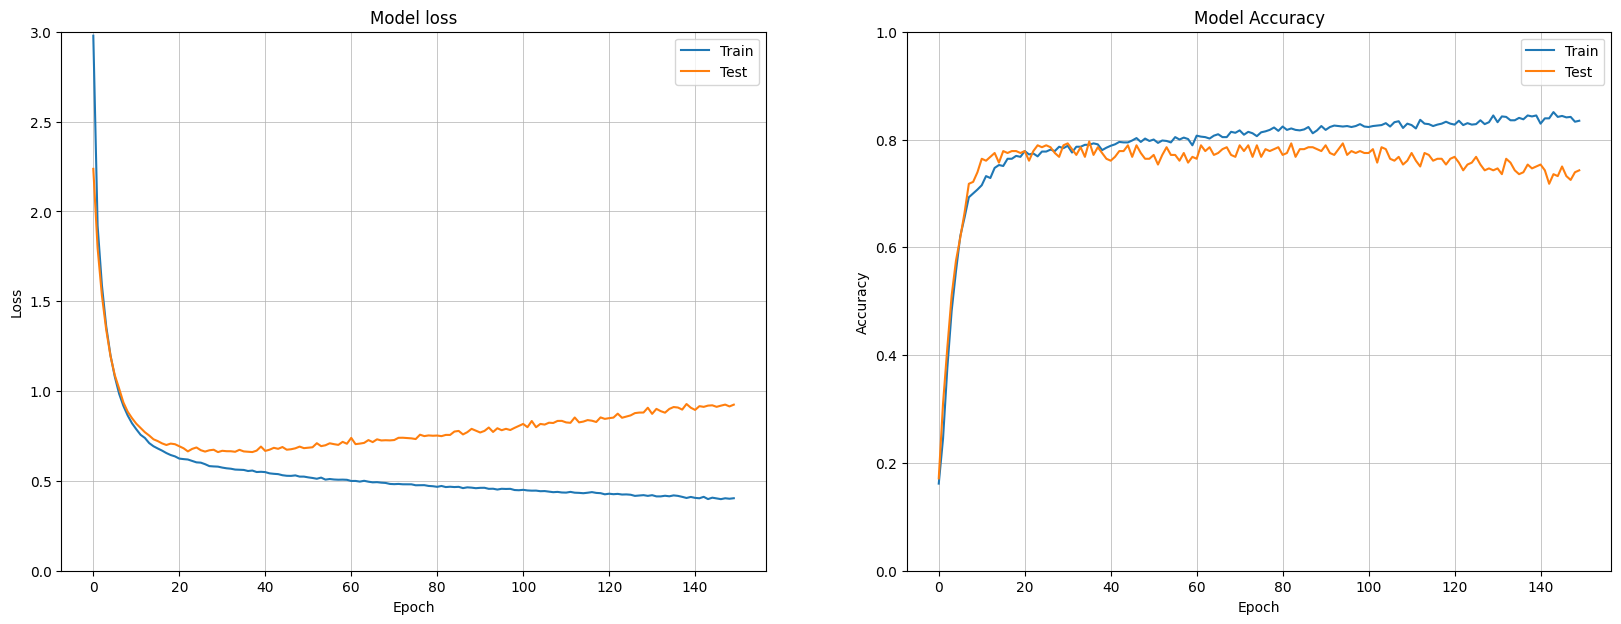

In [15]:
plot_loss_accuracy(history)

# Early Stopping

## Basic

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping()

model = initialize_model()

history = model.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=16,
          epochs=150,
          verbose=1,
          shuffle=True,
                    callbacks=[es])

Epoch 1/150
70/70 [==============================] - 0s 2ms/step - loss: 2.9192 - accuracy: 0.2545 - val_loss: 2.0037 - val_accuracy: 0.3571
Epoch 2/150
70/70 [==============================] - 0s 633us/step - loss: 1.7888 - accuracy: 0.3705 - val_loss: 1.4875 - val_accuracy: 0.4464


In [17]:
results = model.evaluate(X_test, y_test, verbose=0)
accuracy = results[1]
accuracy

0.3933333456516266

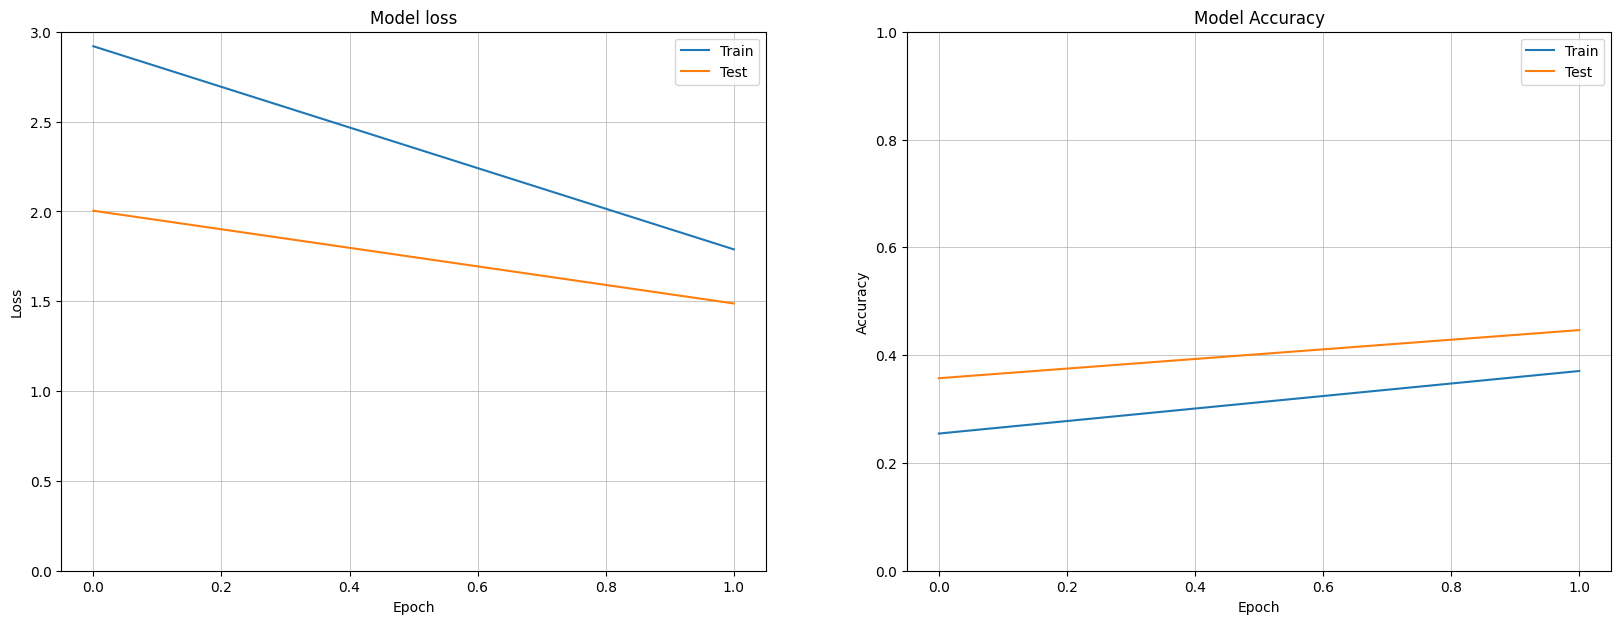

In [18]:
plot_loss_accuracy(history)

## Early Stopping with arguments

In [22]:
es = EarlyStopping(patience=20, restore_best_weights=True)

model = initialize_model()

history = model.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=16,
          epochs=150,
          verbose=1,
          shuffle=True,
                    callbacks=[es])

Epoch 1/150
70/70 [==============================] - 0s 2ms/step - loss: 3.3841 - accuracy: 0.1821 - val_loss: 2.2965 - val_accuracy: 0.2607
Epoch 2/150
70/70 [==============================] - 0s 625us/step - loss: 1.8241 - accuracy: 0.3330 - val_loss: 1.5616 - val_accuracy: 0.4321
Epoch 3/150
70/70 [==============================] - 0s 623us/step - loss: 1.3591 - accuracy: 0.5000 - val_loss: 1.2928 - val_accuracy: 0.5464
Epoch 4/150
70/70 [==============================] - 0s 625us/step - loss: 1.1422 - accuracy: 0.5813 - val_loss: 1.1120 - val_accuracy: 0.6000
Epoch 5/150
70/70 [==============================] - 0s 634us/step - loss: 1.0014 - accuracy: 0.6420 - val_loss: 1.0071 - val_accuracy: 0.6250
Epoch 6/150
70/70 [==============================] - 0s 620us/step - loss: 0.9110 - accuracy: 0.6786 - val_loss: 0.9350 - val_accuracy: 0.6464
Epoch 7/150
70/70 [==============================] - 0s 605us/step - loss: 0.8484 - accuracy: 0.6848 - val_loss: 0.8815 - val_accuracy: 0.6714
E

Epoch 58/150
70/70 [==============================] - 0s 590us/step - loss: 0.4796 - accuracy: 0.8143 - val_loss: 0.6653 - val_accuracy: 0.7571
Epoch 59/150
70/70 [==============================] - 0s 592us/step - loss: 0.4840 - accuracy: 0.8179 - val_loss: 0.6631 - val_accuracy: 0.7643
Epoch 60/150
70/70 [==============================] - 0s 589us/step - loss: 0.4756 - accuracy: 0.8152 - val_loss: 0.6494 - val_accuracy: 0.7607
Epoch 61/150
70/70 [==============================] - 0s 581us/step - loss: 0.4767 - accuracy: 0.8205 - val_loss: 0.6779 - val_accuracy: 0.7536
Epoch 62/150
70/70 [==============================] - 0s 590us/step - loss: 0.4704 - accuracy: 0.8152 - val_loss: 0.6622 - val_accuracy: 0.7714
Epoch 63/150
70/70 [==============================] - 0s 589us/step - loss: 0.4710 - accuracy: 0.8116 - val_loss: 0.6578 - val_accuracy: 0.7679


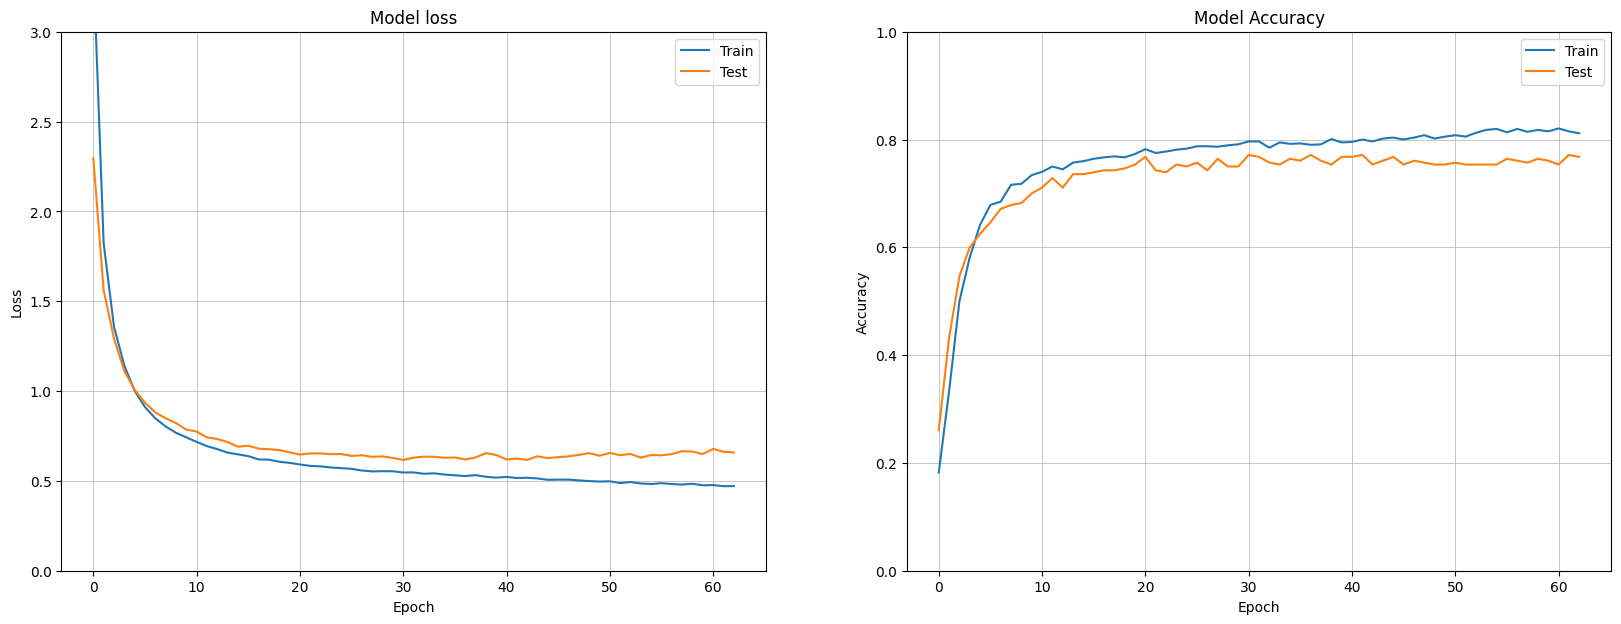

In [23]:
plot_loss_accuracy(history)

In [24]:
results = model.evaluate(X_test, y_test, verbose=0)
accuracy = results[1]
accuracy

0.7400000095367432